In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.utils import plot_model

In [2]:
FILE_PATH = '/content/weather_classification_data.csv'

df = pd.read_csv(FILE_PATH)

df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


In [3]:
df.shape

(13200, 11)

In [4]:
df.isnull().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

### EDA

In [5]:
cols_to_iterate = df.select_dtypes(exclude='number').columns

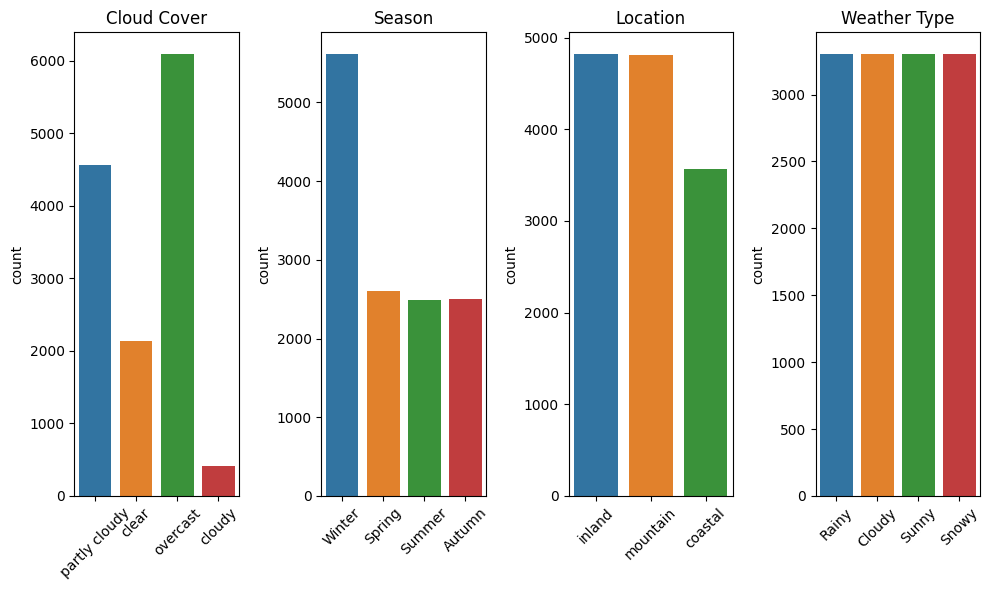

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,6))

for i,col in enumerate(cols_to_iterate):
    k=sns.countplot(data=df,x=col,hue=col,ax=axes[i],legend=False)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

In [7]:
num_types = df.select_dtypes(include='number').columns
num_types

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object')

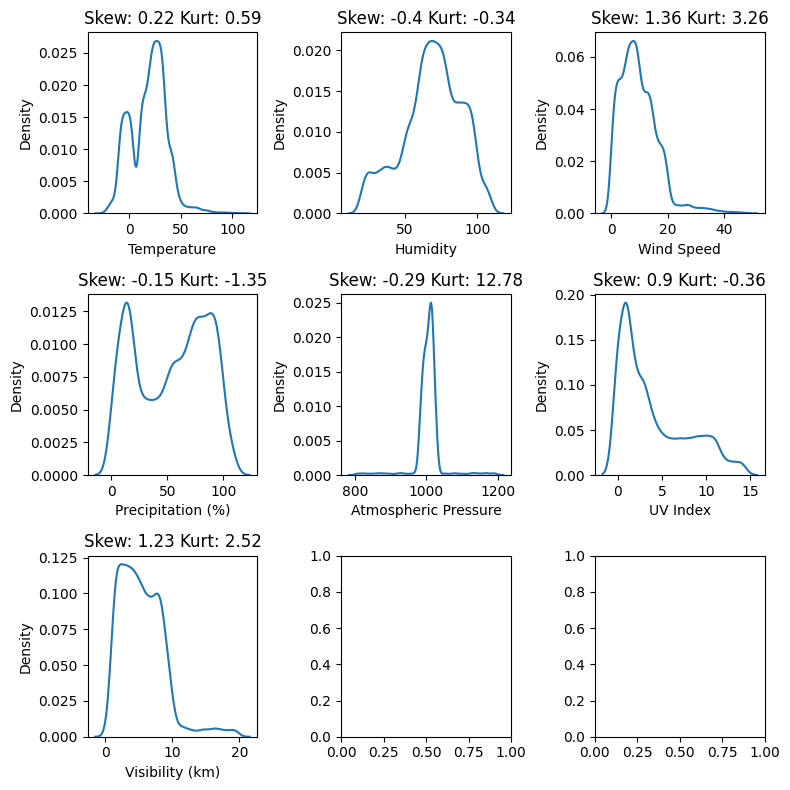

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, col in enumerate(num_types):
    row, col_pos = divmod(i, 3)
    sns.kdeplot(data=df, x=col, ax=axes[row, col_pos])
    skewness = round(stats.skew(df[col], bias=False), 2)
    kurt = round(stats.kurtosis(df[col], bias=False), 2)
    text = f"Skew: {skewness} Kurt: {kurt}"
    axes[row, col_pos].set_title(text)

plt.tight_layout()
plt.show()

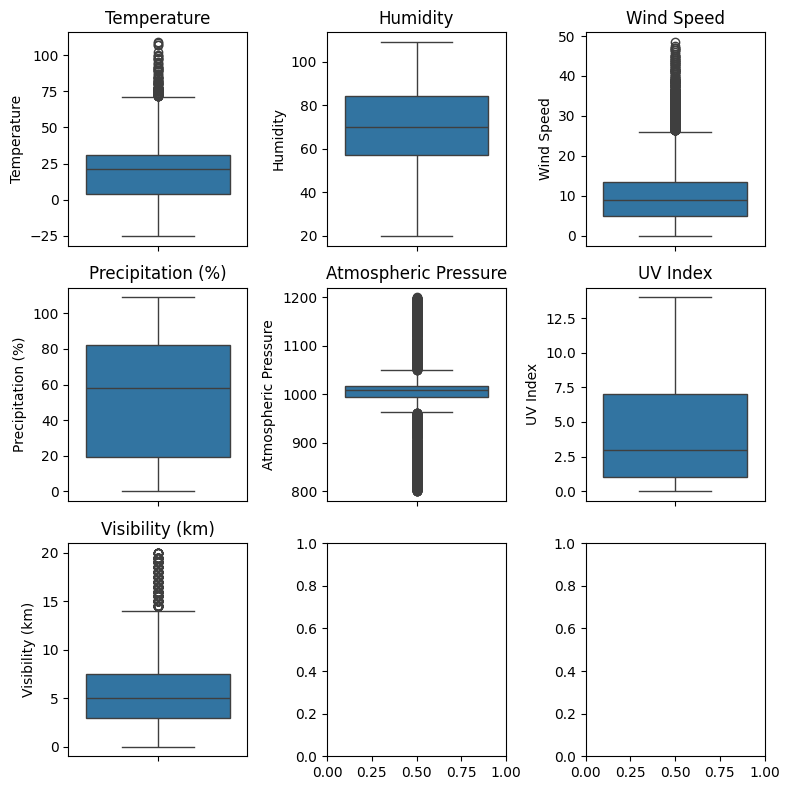

In [9]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(8,8))
ax = ax.flatten()

for i,col in enumerate(num_types):
    sns.boxplot(data=df,y=col,ax=ax[i])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

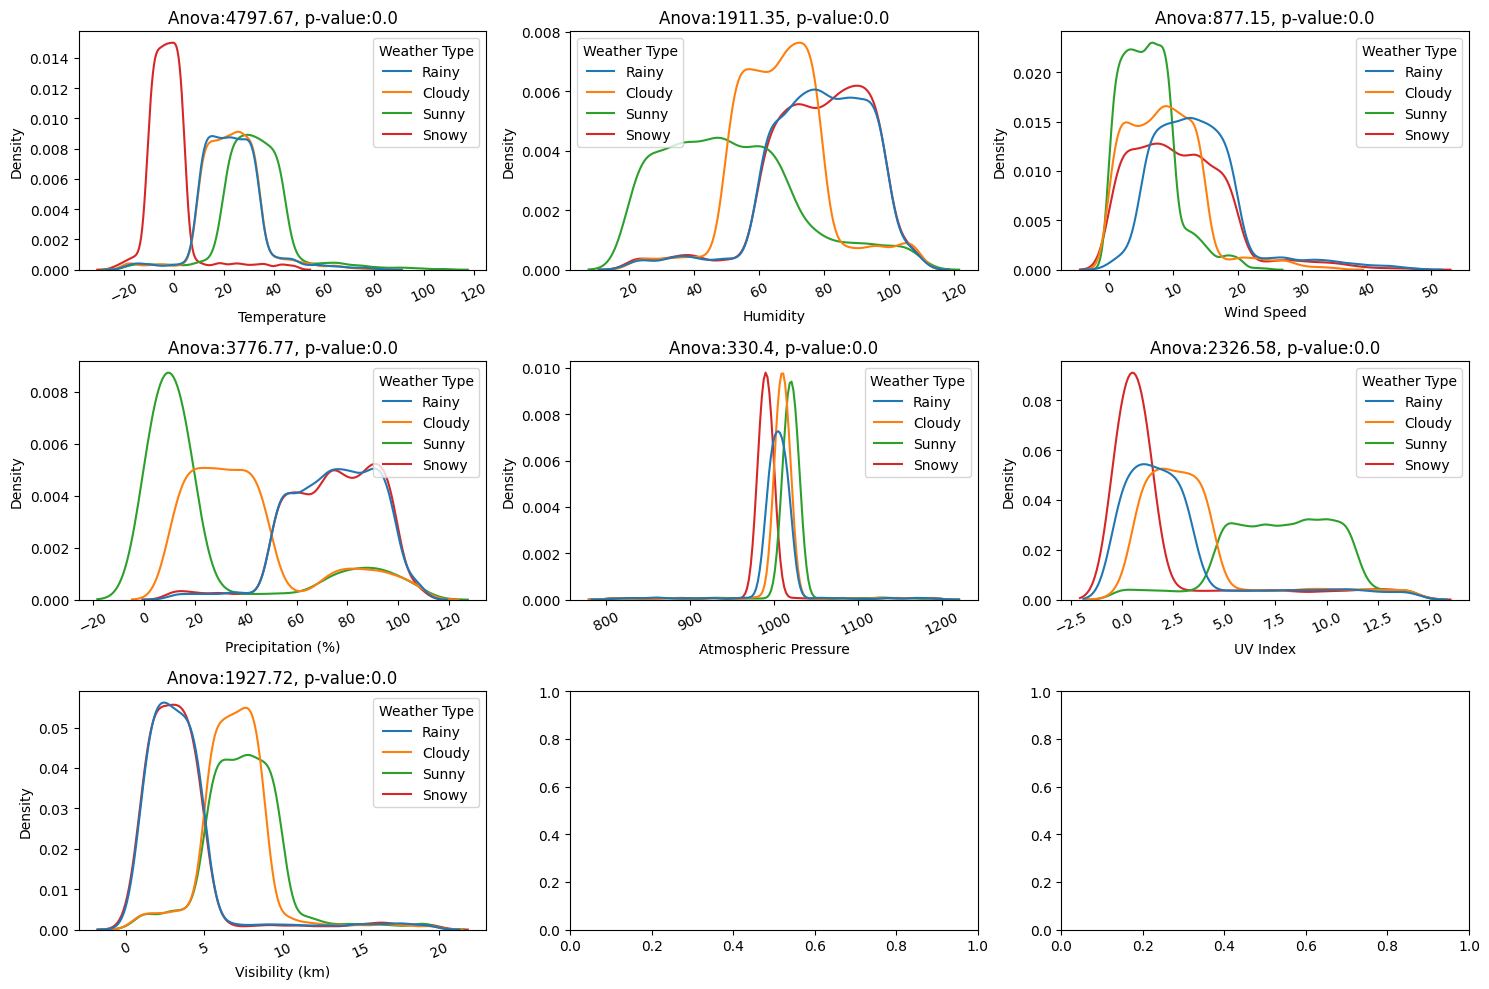

In [10]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(15,10))
ax = ax.flatten()

i=0
num_selected=[]
for col in num_types:
    k=dict(list(df.groupby(df['Weather Type'])[col]))
    f,p=stats.f_oneway(*k.values())
    text_str=f"Anova:{round(f,2)}, p-value:{round(p,2)}"

    if p<0.2 and col not in num_selected:
            num_selected.append(col)

    sns.kdeplot(data=df,x=col,hue=df['Weather Type'],ax=ax[i])
    ax[i].set_title(text_str)
    ax[i].tick_params(axis='x', rotation=25)
    i+=1

plt.tight_layout()
plt.show()

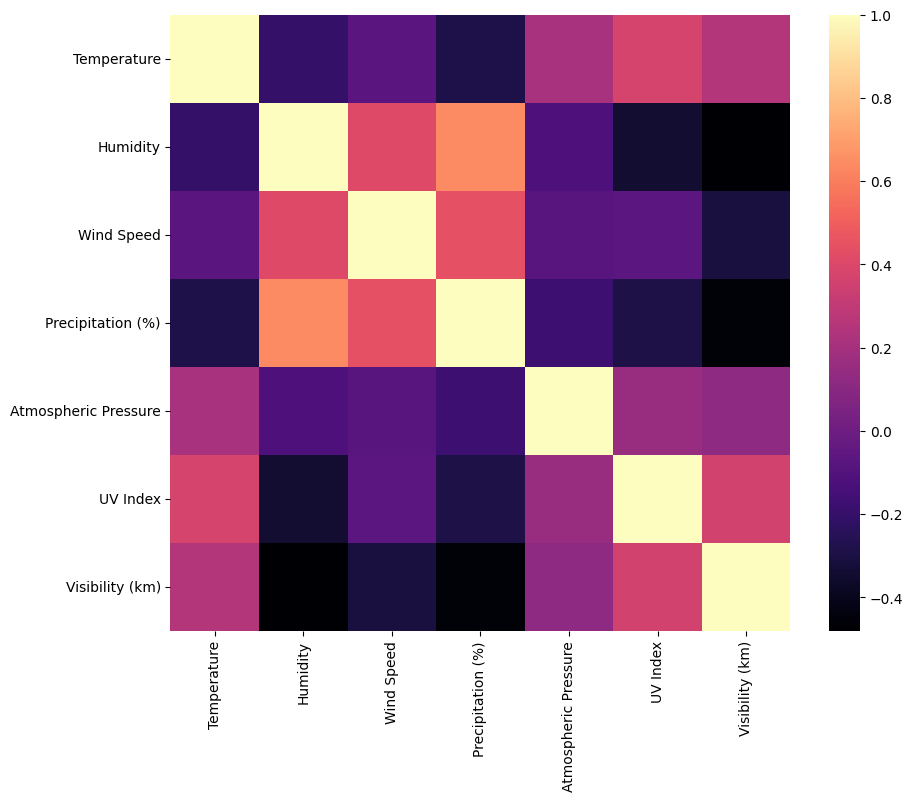

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_types].corr(), cmap='magma')
plt.show()

### Preprocessing

In [12]:
df.select_dtypes(exclude='number').columns

Index(['Cloud Cover', 'Season', 'Location', 'Weather Type'], dtype='object')

In [13]:
df.describe(exclude='number')

,Cloud Cover,Season,Location,Weather Type
count,13200,13200,13200,13200
unique,4,4,3,4
top,overcast,Winter,inland,Rainy
freq,6090,5610,4816,3300


In [14]:
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


In [15]:
labelencoder = LabelEncoder()

df['Cloud Cover'] = labelencoder.fit_transform(df['Cloud Cover'])
df['Season'] = labelencoder.fit_transform(df['Season'])
df['Location'] = labelencoder.fit_transform(df['Location'])

df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1,Rainy
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1,Cloudy
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2,Sunny
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0,Sunny
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,2,1003.15,1,2,1.0,2,Rainy
13196,-1.0,76,3.5,23.0,1,1067.23,1,3,6.0,0,Snowy
13197,30.0,77,5.5,28.0,2,1012.69,3,0,9.0,0,Cloudy
13198,3.0,76,10.0,94.0,2,984.27,0,3,2.0,1,Snowy


In [16]:
data = df.drop('Weather Type', axis=1)

data

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2
...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,2,1003.15,1,2,1.0,2
13196,-1.0,76,3.5,23.0,1,1067.23,1,3,6.0,0
13197,30.0,77,5.5,28.0,2,1012.69,3,0,9.0,0
13198,3.0,76,10.0,94.0,2,984.27,0,3,2.0,1


In [17]:
target = df['Weather Type']

target

0         Rainy
1        Cloudy
2         Sunny
3         Sunny
4         Rainy
          ...  
13195     Rainy
13196     Snowy
13197    Cloudy
13198     Snowy
13199     Rainy
Name: Weather Type, Length: 13200, dtype: object

In [18]:
target = labelencoder.fit_transform(target)

target

array([1, 0, 3, ..., 0, 2, 1])

In [19]:
set(target)

{0, 1, 2, 3}

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10560, 10), (2640, 10), (10560,), (2640,))

In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10560, 10), (2640, 10), (10560,), (2640,))

In [22]:
onehotencoder = OneHotEncoder(sparse=False)

y_train = onehotencoder.fit_transform(y_train.reshape(-1,1))
y_test = onehotencoder.transform(y_test.reshape(-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10560, 10), (2640, 10), (10560, 4), (2640, 4))

In [28]:
model = Sequential([
    Input(X_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

In [35]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

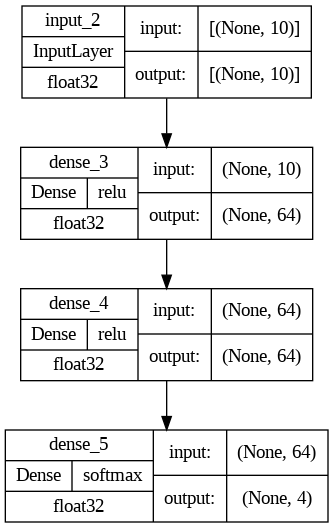

In [34]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [36]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
330/330 [==============================] - 5s 6ms/step - loss: 0.4981 - accuracy: 0.8480
Epoch 2/50
330/330 [==============================] - 1s 4ms/step - loss: 0.2942 - accuracy: 0.8979
Epoch 3/50
330/330 [==============================] - 1s 3ms/step - loss: 0.2536 - accuracy: 0.9062
Epoch 4/50
330/330 [==============================] - 1s 4ms/step - loss: 0.2351 - accuracy: 0.9098
Epoch 5/50
330/330 [==============================] - 1s 4ms/step - loss: 0.2206 - accuracy: 0.9115
Epoch 6/50
330/330 [==============================] - 1s 3ms/step - loss: 0.2104 - accuracy: 0.9151
Epoch 7/50
330/330 [==============================] - 1s 3ms/step - loss: 0.2024 - accuracy: 0.9182
Epoch 8/50
330/330 [==============================] - 1s 4ms/step - loss: 0.1969 - accuracy: 0.9168
Epoch 9/50
330/330 [==============================] - 2s 5ms/step - loss: 0.1913 - accuracy: 0.9204
Epoch 10/50
330/330 [==============================] - 2s 6ms/step - loss: 0.1860 - accuracy: 0.9208

In [37]:
model.evaluate(X_test, y_test)

83/83 [==============================] - 1s 3ms/step - loss: 0.2653 - accuracy: 0.9095


[0.2653183043003082, 0.909469723701477]